In [ ]:
!pip install pmdarima
!pip install yfinance
!pip install xgboost



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 1.5 MB/s eta 0:01:43
   ---------------------------------------- 0.8/150.0 MB 1.5 MB/s eta 0:01:43
   ---------------------------------------- 1.3/150.0 MB 1.5 MB/s eta 0:01:42
   ---------------------------------------- 1.8/150.0 MB 1.7 MB/s eta 0:01:26
    --------------------------------------- 2.9/150.0 MB 2.2 MB/s eta 0:01:07
    --------------------------------------- 3.7/150.0 MB 2.5 MB/s eta 0:01:00
   - -------------------------------------- 4.5/150.0 MB 2.6 MB/s eta 0:00:56
   - -------------------------------------- 4.7/150.0 MB 2.6 MB/s eta 0:00:57
   - -------------------------------------- 5.0/150.0 MB 2.4 MB/s eta 0:01:01
   - -------------------------------------- 5.8/150.0 MB 2.5 MB/s eta 0:00:58
   - -------------------------------------- 6.3/150.0 MB 2.6 MB/s eta 0:00:57



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [13]:
# Define stock list (same as used in RL notebook)
stock_list = ['AAPL', 'MSFT', 'GOOG']  # Add more if needed

# Set date range
date_start = "2015-01-01"
date_end = "2020-12-31"

# Results dict
results = {
    "Stock": [],
    "LSTM_RMSE": [],
    "XGBoost_RMSE": []
}

# LSTM configuration
window_size = 60
epochs = 10
batch_size = 16

In [15]:
for stock in stock_list:
    print(f"\nProcessing {stock}...")

    # Download data
    df = yf.download(stock, start=date_start, end=date_end)
    df = df[["Close"]].dropna()

    # Split train/test
    split = int(len(df) * 0.8)
    train_data = df[:split]
    test_data = df[split:]

    # Normalize for LSTM
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train_data)
    scaled_all = scaler.transform(df)

    # Prepare LSTM sequences
    X_train, y_train = [], []
    for i in range(window_size, len(scaled_train)):
        X_train.append(scaled_train[i-window_size:i, 0])
        y_train.append(scaled_train[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Prepare test input
    inputs = scaled_all[len(scaled_all) - len(test_data) - window_size:]
    X_test = []
    for i in range(window_size, len(inputs)):
        X_test.append(inputs[i-window_size:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Predict and inverse scale
    predicted_scaled = model.predict(X_test)
    predicted = scaler.inverse_transform(predicted_scaled)
    real = test_data["Close"].values


    lstm_rmse = np.sqrt(mean_squared_error(real, predicted))

    # === XGBoost ===
    xgb_df = df.copy()
    xgb_df['Target'] = xgb_df['Close'].shift(-1)
    xgb_df.dropna(inplace=True)

    for lag in range(1, 6):
        xgb_df[f"Lag_{lag}"] = xgb_df["Close"].shift(lag)
    xgb_df.dropna(inplace=True)

    X = xgb_df[[f"Lag_{lag}" for lag in range(1, 6)]]
    y = xgb_df["Target"]

    X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, shuffle=False, test_size=0.2)
    model_xgb = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
    model_xgb.fit(X_train_xgb, y_train_xgb)
    xgb_pred = model_xgb.predict(X_test_xgb)
    xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, xgb_pred))

    # Store results
    results["Stock"].append(stock)
    results["LSTM_RMSE"].append(round(lstm_rmse, 2))
    results["XGBoost_RMSE"].append(round(xgb_rmse, 2))

    print(f"LSTM RMSE: {lstm_rmse:.2f}, XGBoost RMSE: {xgb_rmse:.2f}")


[*********************100%***********************]  1 of 1 completed


Processing AAPL...


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
LSTM RMSE: 6.95, XGBoost RMSE: 38.06

Processing MSFT...


[*********************100%***********************]  1 of 1 completed


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
LSTM RMSE: 13.47, XGBoost RMSE: 54.80

Processing GOOG...


[*********************100%***********************]  1 of 1 completed


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
LSTM RMSE: 3.95, XGBoost RMSE: 15.49


In [16]:
# Display final table
results_df = pd.DataFrame(results)
print("\nFinal RMSE Comparison:")
print(results_df)


Final RMSE Comparison:
  Stock  LSTM_RMSE  XGBoost_RMSE
0  AAPL       6.95         38.06
1  MSFT      13.47         54.80
2  GOOG       3.95         15.49


[*********************100%***********************]  1 of 1 completed


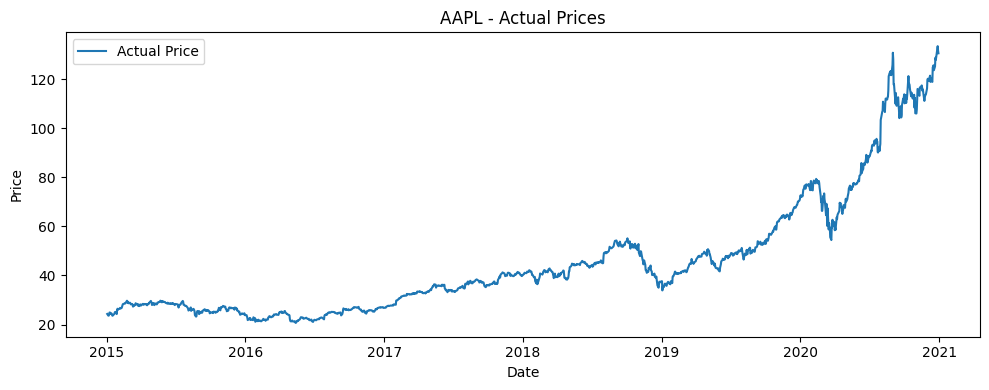

In [17]:

# Plotting example for first stock
example_stock = stock_list[0]
df_plot = yf.download(example_stock, start=date_start, end=date_end)[["Close"]]
plt.figure(figsize=(10, 4))
plt.plot(df_plot["Close"], label="Actual Price")
plt.title(f"{example_stock} - Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()
